In [7]:
import torch
import triton

BLOCK_SIZE = 32
device = torch.device("cuda")

from numba_mm import launch_naive_numba_matmul

In [8]:
def matmul(a, b):
    M, N, K = a.shape[0], b.shape[1], a.shape[1]
    out = torch.zeros(M, N, dtype=a.dtype, device=a.device)
    launch_naive_numba_matmul(out, a, b, M, N, K, BLOCK_SIZE)
    torch.cuda.synchronize()
    return out

In [9]:
for size in [128 * i for i in range(2, 33)]:
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    assert torch.allclose(torch.matmul(a, b), matmul(a, b), atol=5e-4), size

In [10]:
@triton.testing.perf_report(
    triton.testing.Benchmark(x_names=['size'],
                             x_vals=[128 * i for i in range(2, 33)],
                             line_arg='provider',
                             line_vals=['numba', 'torch'],
                             line_names=[
                                 "Numba",
                                 "Torch",
                             ],
                             styles=[('blue', '-'), ('green', '-')],
                             ylabel="TFLOPS",
                             plot_name="naive-numba-matmul-perf",
                             args={}))
def benchmark(size, provider):
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    quantiles = [0.5, 0.8, 0.2]
    if provider == 'torch':
        ms, max_ms, min_ms = triton.testing.do_bench(
            lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'numba':
        ms, max_ms, min_ms = triton.testing.do_bench(lambda: matmul(a, b),
                                                     quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

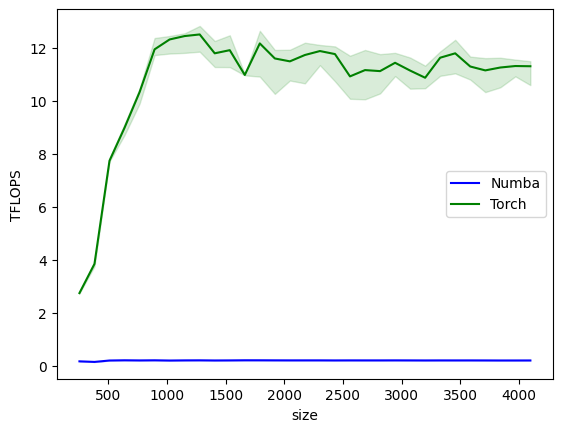

naive-numba-matmul-perf:
      size     Numba      Torch
0    256.0  0.170611   2.744963
1    384.0  0.148964   3.846678
2    512.0  0.202009   7.738568
3    640.0  0.210353   8.982456
4    768.0  0.205181  10.325147
5    896.0  0.209905  11.940955
6   1024.0  0.201228  12.313553
7   1152.0  0.206827  12.441600
8   1280.0  0.208858  12.502695
9   1408.0  0.203444  11.790811
10  1536.0  0.206095  11.909058
11  1664.0  0.210708  10.974283
12  1792.0  0.210223  12.163879
13  1920.0  0.208149  11.596556
14  2048.0  0.206825  11.487310
15  2176.0  0.207251  11.727174
16  2304.0  0.207438  11.876389
17  2432.0  0.205158  11.761926
18  2560.0  0.206649  10.919994
19  2688.0  0.206163  11.157910
20  2816.0  0.206027  11.119160
21  2944.0  0.207449  11.433438
22  3072.0  0.206007  11.139702
23  3200.0  0.204382  10.869046
24  3328.0  0.205859  11.624947
25  3456.0  0.205443  11.790334
26  3584.0  0.205892  11.293355
27  3712.0  0.204791  11.146380
28  3840.0  0.202967  11.255038
29  3968.0  0.2

In [11]:
benchmark.run(show_plots=True, print_data=True)

In [12]:
torch.cuda.empty_cache()